In [1]:
from flask import Flask, render_template,flash,request
import pandas as pd
import json
from minepy import MINE
import numpy as np
import matplotlib.pyplot as plt
#from array2gif import write_gif
from os import listdir
from os.path import isfile, join
from scipy.spatial import Delaunay

import seaborn as sns
import pysal as ps
import geopandas as gpd
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import date
import pickle
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from PIL import Image, ImageDraw
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import pickle
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import griddata
from PIL import Image, ImageDraw
from shapely.geometry import Point
import geopandas

#plot convert to image

_errstr = "Mode is unknown or incompatible with input array shape."
def bytescale(data, cmin=None, cmax=None, high=255, low=0):

    if data.dtype == np.uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint8)


def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):

    data = np.asarray(arr)
    if np.iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (np.arange(0, 256, 1, dtype=np.uint8)[:, np.newaxis] *
                       np.ones((3,), dtype=np.uint8)[np.newaxis, :])
                image.putpalette(np.asarray(pal, dtype=np.uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = np.amin(np.ravel(data))
        if cmax is None:
            cmax = np.amax(np.ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(np.asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(np.asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = np.transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = np.transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image
#spots.shape

C:\Users\vislab_shs\Anaconda3\envs\gluon\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Users\vislab_shs\Anaconda3\envs\gluon\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [6]:
location=pd.read_csv('data/location_seoul_413.csv')
location['no'] = location['no'].astype(str)
array=np.load("data/array_413.npy")
array.shape,location.shape
df=pd.DataFrame({"pm25":array[0,:,3],"lat":location["lat"].values,"lon":location["long"]})
# combine lat and lon column to a shapely Point() object
df['geometry'] = df.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)
df = geopandas.GeoDataFrame(df, geometry='geometry')
df.to_file('data/MyGeometries.shp', driver='ESRI Shapefile')
points=[(location['lat'][i],location['long'][i]) for i in range(location.shape[0])]

((1800, 413, 5), (413, 6))

In [ ]:
#weight for spatial autocorrelation
kw=ps.lib.weights.Kernel(points,fixed = False,function = 'gaussian')

### Moran's I

In [23]:
#getting moran's i (t=0) (# of features=5)
for i in range(5):
    y=array[0,:,i]
    mi=ps.explore.esda.Moran(y, kw, two_tailed=False)
    print(mi.I,mi.p_norm)

0.5028236696475865 0.0
0.5321974760714278 0.0
0.7034007358581101 0.0
0.6798558450200852 0.0
0.5325154020184095 0.0


In [34]:
#getting moran's i (time length=1800) (# of features=5) 
#dimension: mor[feature][time]
mor=[[],[],[],[],[]]
for v in range(5):
    for t in range(1800):
        if np.isnan(array[t,0,v]): continue
        y=array[t,:,v]
        mi=ps.explore.esda.Moran(y, kw, two_tailed=False)
        mor[v].append(mi)
#save
with open('data/moranslist.pickle', 'wb') as handle:
    pickle.dump(mor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
#laod
with open('data/moranslist.pickle', 'rb') as handle:
    moranslist = pickle.load(handle)

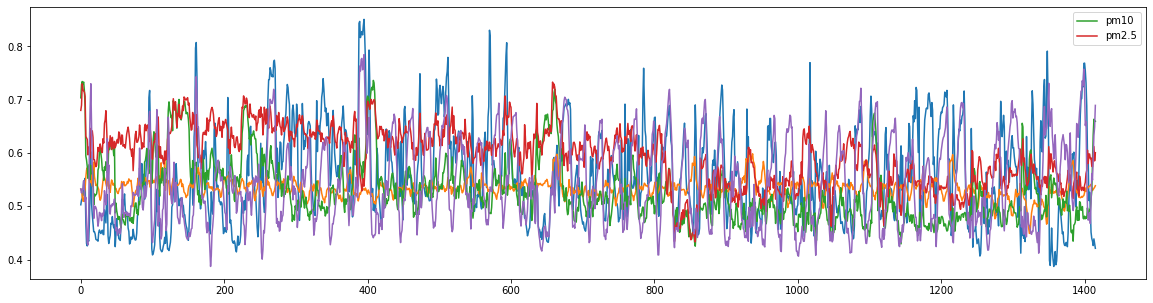

In [123]:
plt.figure(figsize=(20,5))
plt.plot([mor[0][i].I for i in range(len(mor[0]))])
plt.plot([mor[1][i].I for i in range(len(mor[0]))])
plt.plot([mor[2][i].I for i in range(len(mor[0]))],label="pm10")
plt.plot([mor[3][i].I for i in range(len(mor[0]))],label="pm2.5")
plt.plot([mor[4][i].I for i in range(len(mor[0]))])
plt.legend()
plt.show()

### LISA

In [40]:
#you sould select y
y=array[900,:,4]
lisa=ps.explore.esda.Moran_Local(y,kw)

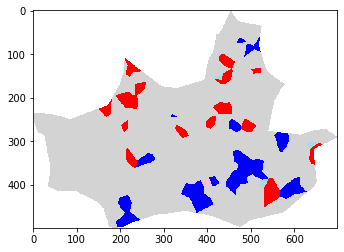

In [51]:
#getting LISA visualization
#kw=ps.lib.weights.Kernel(points,fixed = False,function = 'gaussian')
#y=np_true[0,:]
lisa=ps.explore.esda.Moran_Local(y,kw)

sig = 1 * (lisa.p_sim < 0.05)
hotspot = 1 * (sig * lisa.q==1)
coldspot = 3 * (sig * lisa.q==3)
doughnut = 2 * (sig * lisa.q==2)
diamond = 4 * (sig * lisa.q==4)
spots = hotspot + coldspot + doughnut + diamond

spot_labels =[]
l_c=[]
if Counter(spots)[0]>0:
    l_c.append('lightgrey')
if Counter(spots)[1]>0:
    l_c.append('red')
if Counter(spots)[2]>0:
    l_c.append('lightblue')
if Counter(spots)[3]>0:
    l_c.append('blue')
if Counter(spots)[4]>0:
    l_c.append('pink')
spot_labels

spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

r=500;c=700
sc1=MinMaxScaler(feature_range=(0,r-1))
lat=sc1.fit_transform((location['lat'].values).reshape((-1,1))).flatten()
sc2=MinMaxScaler(feature_range=(0,c-1))
long=sc2.fit_transform((location['long'].values).reshape((-1,1))).flatten()

grid_array = np.empty((r, c))
grid_array=grid_array*np.nan
for lt,lg,i in zip(lat,long,spots):
    grid_array[int(lt),int(lg)]=str(i)
    
mask = Image.open("static/images/mask.png")
ma_array=np.ma.array(grid_array, mask=np.isnan(grid_array).astype('bool'))
xx, yy = np.meshgrid(np.arange(0,c), np.arange(0,r))
x1 = xx[~ma_array.mask]
y1 = yy[~ma_array.mask]
newarr = ma_array[~ma_array.mask]
x_inter1=griddata((x1, y1), newarr.ravel(),(xx, yy),method='nearest')
x_inter1=np.flip(x_inter1,axis=0)

cm = plt.get_cmap(colors.ListedColormap(l_c),lut=3)#cm = plt.get_cmap('gist_rainbow')
colored_image = cm(x_inter1/4)
colored_image=toimage(colored_image, cmin=0, cmax=1)
colored_image.putalpha(mask)
plt.imshow(colored_image,vmin=0,vmax=1)

In [52]:
#save png
colored_image.save("result_img/test.png")